In [1]:
import pandapower as pp
from pandapower.plotting.plotly import simple_plotly
import pandapower.plotting as pplot
from math import sqrt

In [2]:
#Create the network:
net = pp.create_empty_network() 

#Define Voltages:
V_h_kV=132 #High voltage coming from the external grid
V_int_kV=11 #Intermediate voltage after first trafo
V_l_kV = 0.415 #low voltage after second trafo. Is the input voltage for the loads.

#Define high voltage bus of trafo 1:
b1_h=pp.create_bus(net, vn_kv=V_h_kV, name="Bus 1_h",geodata=((0,350))) 

#Define Swing bus:
pp.create_ext_grid(net, bus=b1_h, vm_pu=1, name="Swing bus (Grid Connection)")

#Define a function to create one bus: 
def create_bus(net,v,busName,current_geodata):
    return pp.create_bus(net, vn_kv=v, name=busName,geodata=current_geodata)

#Define a function to create a group of buses for each cluster:
def create_bus_group(quantity,net,v,cluster_number,add,geodata):
    bus=[]
    for i in range(quantity):
        bus.append(create_bus(net,v,f"Bus {i + add} for cluster {cluster_number}",geodata[i]))
    return bus

#Define a function to create a line:
def create_line(net,bus_from,bus_to,length,r_lv_ohm_per_km,x_lv_ohm_per_km,c_lv_nf_per_km,imax_lv_ka):
    pp.create_line_from_parameters(net,from_bus=bus_from,to_bus=bus_to,length_km=length,r_ohm_per_km=r_lv_ohm_per_km,x_ohm_per_km=x_lv_ohm_per_km,c_nf_per_km=c_lv_nf_per_km, max_i_ka=imax_lv_ka,name=f"Line from bus {bus_from} to bus {bus_to}")

#Define a function to create a group of lines:       
def create_lines(net,primary_bus,buses, primary_distance,distance,r_lv_ohm_per_km,x_lv_ohm_per_km,c_lv_nf_per_km,imax_lv_ka):
    for i in range(len(buses)):
        if i == 0: #Lines connected to the LV side of the secondary trafo:
            create_line(net,primary_bus,buses[i],primary_distance,r_lv_ohm_per_km,x_lv_ohm_per_km,c_lv_nf_per_km,imax_lv_ka)
        else: #Lines in each cluster without including the connection to the secondary trafo
            create_line(net,buses[i-1],buses[i],distance,r_lv_ohm_per_km,x_lv_ohm_per_km,c_lv_nf_per_km,imax_lv_ka)

#Define a function to create a load
def create_load(net,current_bus,p_per_house_mw,houses_per_bus,q_per_house_mvar,current_name):
    pp.create_load(net,bus=current_bus,p_mw=p_per_house_mw*houses_per_bus,q_mvar=q_per_house_mvar*houses_per_bus,name=current_name)

#Define a function to create a group of loads for each cluster:
def create_loads(net,p_per_house_mw,houses_per_bus,q_per_house_mvar,buses,add_one_house):
    for i in range(len(buses)):
        if(add_one_house and i == len(buses)-1):
            houses_per_bus=houses_per_bus+1 #Add one house in the last bus of the right block of each cluster.
        create_load(net,buses[i],p_per_house_mw,houses_per_bus,q_per_house_mvar,f"Load at bus {i}")

#Define a function to create a cluster:
def create_cluster(cluster_number,geodata_left,geodata_right,primary_bus_geodata):
    primary_bus = create_bus(net,V_l_kV,f"primary bus for cluster {cluster_number}",primary_bus_geodata)   
    quantity_of_buses_left = 4  #Define buses in the left block of each cluster
    quantity_of_buses_right = 3 #Define buses in the right block of each cluster
    b_left = create_bus_group(quantity_of_buses_left,net,V_l_kV,cluster_number, 0,geodata_left) #Create the buses of the left block 
    b_right = create_bus_group(quantity_of_buses_right,net,V_l_kV,cluster_number, quantity_of_buses_left,geodata_right) #Create the buses of the right block
    primary_distance = (55+75)/1000 #Distance between LV side of secondary trafo and first bus of both blocks of each cluster.
    distance = 150/1000 #Distance between buses in both blocks without including connection to LV side of secondary trafo.
    
    #Chosen wire for LV: BS 5467 SWA PVC BASEC 0.6/1kV Cable, 4 cores, with a 70 mm2 cross-sectional area. Characteristics:
    r_lv_ohm_per_km = 0.59
    x_lv_ohm_per_km = 0.13
    c_lv_nf_per_km = 0 #Capacitance assumed as 0 for being a LV cable.
    imax_lv_ka = 0.167
    
    create_lines(net,primary_bus,b_left,primary_distance,distance,r_lv_ohm_per_km,x_lv_ohm_per_km,c_lv_nf_per_km,imax_lv_ka)
    create_lines(net,primary_bus,b_right,primary_distance,distance,r_lv_ohm_per_km,x_lv_ohm_per_km,c_lv_nf_per_km,imax_lv_ka)


    #Define loads characteristics:
    power_factor=0.9 #Standard power factor for dwellings
    q_mvar_multiplier = sqrt(power_factor**-2-1) #=tan(arccos(power_factor))
    p_per_house_mw=0.003

    #Define solar PV characteristics:
    cappeak=0.0012 #rated peak capacity per household
    solareff=0 #efficiency of each panel. Assumed as 0 to design power grid for worst case scenario.

    p_per_house_mw=p_per_house_mw-cappeak*solareff #New load with solar power. Defined as negative load due to the generation.
    q_per_house_mvar=p_per_house_mw*q_mvar_multiplier

    #Define loads in a Cluster 
    houses_per_bus=6 #3 houses per load, 2 loads per bus

    create_loads(net,p_per_house_mw,houses_per_bus,q_per_house_mvar,b_left,False)
    create_loads(net,p_per_house_mw,houses_per_bus,q_per_house_mvar,b_right,True)
    return primary_bus

#Define intermeditate voltage bus of trafo 1:
b1_int=pp.create_bus(net, vn_kv=V_int_kV, name="Bus 1_int",geodata=((0,0))) 

#Define trafo 1:
pp.create_transformer_from_parameters(net, hv_bus=b1_h, lv_bus=b1_int, sn_mva = 1.5, vn_hv_kv=V_h_kV, vn_lv_kv=V_int_kV, vkr_percent = 1, vk_percent = 10, pfe_kw = 15, i0_percent = 5, name ="Transformer 1")

#Chosen wire for MV: BS 6622 XLPE PVC 6.35/11 kV Cable, 3 cores, with a 35 mm2 cross-sectional area. Characteristics:
r_intv_ohm_per_km = 0.524
x_intv_ohm_per_km = 0.138
c_intv_nf_per_km = 219
imax_intv_ka = 0.170

primary_buses=[]

#Define buses and clusters geodata:
b2_int_buses_geodata=[((-10,110)),((-10,-110)),((10,110)),((10,-110))]
primary_buses_geodata=[((-60,110)),((-60,-110)),((60,110)),((60,-110))]
geodata_left_clusters=[[((-85,165)),((-235,165)),((-385,165)),((-535,165))],[((-85,-55)),((-235,-55)),((-385,-55)),((-535,-55))],[((85,165)),((235,165)),((385,165)),((535,165))],[((85,-55)),((235,-55)),((385,-55)),((535,-55))]]
geodata_right_clusters=[[((-85,55)),((-235,55)),((-385,55))],[((-85,-165)),((-235,-165)),((-385,-165))],[((85,55)),((235,55)),((385,55))],[((85,-165)),((235,-165)),((385,-165))]]

#Creates all the elements for each cluster:
for i in range(4):
    b2_int=pp.create_bus(net, vn_kv=V_int_kV, name=f"Int Bus for cluster {i}",geodata=b2_int_buses_geodata[i])
    length = 120/1000 #MV cable distance for each cluster.
    pp.create_line_from_parameters(net,from_bus=b1_int,to_bus=b2_int,length_km=length,r_ohm_per_km=r_intv_ohm_per_km,x_ohm_per_km=x_intv_ohm_per_km,c_nf_per_km=c_intv_nf_per_km, max_i_ka=imax_intv_ka,name=f"Primary Line for transformer for cluster {i}")
    primary_buses.append(create_cluster(i,geodata_left_clusters[i],geodata_right_clusters[i],primary_buses_geodata[i])) #Stores the information of the primary buses of each cluster. 
    pp.create_transformer_from_parameters(net, hv_bus=b2_int, lv_bus=primary_buses[i], sn_mva = 0.315, vn_hv_kv=V_int_kV, vn_lv_kv=V_l_kV, vkr_percent = 1, vk_percent = 10, pfe_kw = 15, i0_percent = 5,name=f"Int Tranformer for cluster {i}")   
    
pp.runpp(net) #Solve the power flow
net #Show all elements of the net

This pandapower network includes the following parameter tables:
   - bus (38 elements)
   - load (28 elements)
   - ext_grid (1 element)
   - line (32 elements)
   - trafo (5 elements)
   - bus_geodata (38 elements)
 and the following results tables:
   - res_bus (38 elements)
   - res_line (32 elements)
   - res_trafo (5 elements)
   - res_ext_grid (1 element)
   - res_load (28 elements)

In [3]:
net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,Primary Line for transformer for cluster 0,None,1,2,0.12,0.524,0.138,219.0,0.0,0.170,1.0,1,None,True
1,Line from bus 3 to bus 4,None,3,4,0.13,0.590,0.130,0.0,0.0,0.167,1.0,1,None,True
2,Line from bus 4 to bus 5,None,4,5,0.15,0.590,0.130,0.0,0.0,0.167,1.0,1,None,True
3,Line from bus 5 to bus 6,None,5,6,0.15,0.590,0.130,0.0,0.0,0.167,1.0,1,None,True
4,Line from bus 6 to bus 7,None,6,7,0.15,0.590,0.130,0.0,0.0,0.167,1.0,1,None,True
5,Line from bus 3 to bus 8,None,3,8,0.13,0.590,0.130,0.0,0.0,0.167,1.0,1,None,True
6,Line from bus 8 to bus 9,None,8,9,0.15,0.590,0.130,0.0,0.0,0.167,1.0,1,None,True
7,Line from bus 9 to bus 10,None,9,10,0.15,0.590,0.130,0.0,0.0,0.167,1.0,1,None,True
8,Primary Line for transformer for cluster 1,None,1,11,0.12,0.524,0.138,219.0,0.0,0.170,1.0,1,None,True
9,Line from bus 12 to bus 13,None,12,13,0.13,0.590,0.130,0.0,0.0,0.167,1.0,1,None,True


In [4]:
net.bus

,name,vn_kv,type,zone,in_service
0,Bus 1_h,132.000,b,None,True
1,Bus 1_int,11.000,b,None,True
2,Int Bus for cluster 0,11.000,b,None,True
3,primary bus for cluster 0,0.415,b,None,True
4,Bus 0 for cluster 0,0.415,b,None,True
5,Bus 1 for cluster 0,0.415,b,None,True
6,Bus 2 for cluster 0,0.415,b,None,True
7,Bus 3 for cluster 0,0.415,b,None,True
8,Bus 4 for cluster 0,0.415,b,None,True
9,Bus 5 for cluster 0,0.415,b,None,True


In [5]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-0.640244,-0.419263
1,0.971176,-2.329507,0.000000,0.000000
2,0.971082,-2.328325,0.000000,0.000000
3,0.942474,-5.115823,0.000000,0.000000
4,0.900921,-4.544632,0.018000,0.008718
5,0.864431,-4.005706,0.018000,0.008718
6,0.839841,-3.620295,0.018000,0.008718
7,0.827465,-3.418981,0.018000,0.008718
8,0.910768,-4.668522,0.018000,0.008718
9,0.885477,-4.292660,0.018000,0.008718


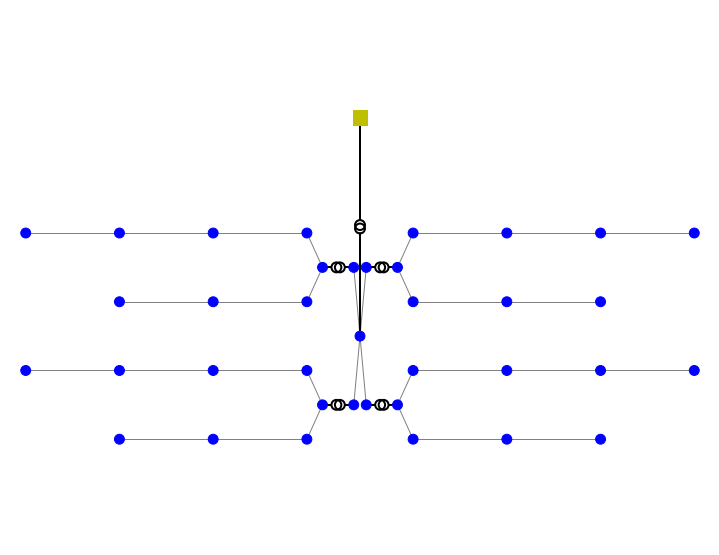

<AxesSubplot:>

In [6]:
pplot.simple_plot(net)

In [7]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,0.155513,0.077910,-0.155496,-0.078848,0.000017,-0.000938,0.009400,0.009423,0.009423,0.971176,-2.329507,0.971082,-2.328325,5.543081
1,0.079961,0.036625,-0.076083,-0.035771,0.003878,0.000855,0.129824,0.129824,0.129824,0.942474,-5.115823,0.900921,-4.544632,77.739047
2,0.058083,0.027053,-0.055483,-0.026480,0.002599,0.000573,0.098943,0.098943,0.098943,0.900921,-4.544632,0.864431,-4.005706,59.247208
3,0.037483,0.017762,-0.036300,-0.017502,0.001183,0.000261,0.066756,0.066756,0.066756,0.864431,-4.005706,0.839841,-3.620295,39.973554
4,0.018300,0.008784,-0.018000,-0.008718,0.000300,0.000066,0.033626,0.033626,0.033626,0.839841,-3.620295,0.827465,-3.418981,20.135167
5,0.060884,0.028462,-0.058620,-0.027963,0.002265,0.000499,0.099208,0.099208,0.099208,0.942474,-5.115823,0.910768,-4.668522,59.406121
6,0.040620,0.019245,-0.039368,-0.018970,0.001252,0.000276,0.068659,0.068659,0.068659,0.910768,-4.668522,0.885477,-4.292660,41.113078
7,0.021368,0.010252,-0.021000,-0.010171,0.000368,0.000081,0.037236,0.037236,0.037236,0.885477,-4.292660,0.871771,-4.081220,22.297132
8,0.155513,0.077910,-0.155496,-0.078848,0.000017,-0.000938,0.009400,0.009423,0.009423,0.971176,-2.329507,0.971082,-2.328325,5.543081
9,0.079961,0.036625,-0.076083,-0.035771,0.003878,0.000855,0.129824,0.129824,0.129824,0.942474,-5.115823,0.900921,-4.544632,77.739047


In [8]:
net.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service
0,Transformer 1,None,0,1,1.500,132.0,11.000,10.0,1.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1,1.0,True
1,Int Tranformer for cluster 0,None,2,3,0.315,11.0,0.415,10.0,1.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1,1.0,True
2,Int Tranformer for cluster 1,None,11,12,0.315,11.0,0.415,10.0,1.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1,1.0,True
3,Int Tranformer for cluster 2,None,20,21,0.315,11.0,0.415,10.0,1.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1,1.0,True
4,Int Tranformer for cluster 3,None,29,30,0.315,11.0,0.415,10.0,1.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1,1.0,True


In [9]:
net.res_trafo

,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,pl_mw,ql_mvar,i_hv_ka,i_lv_ka,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree,loading_percent
0,0.640244,0.419263,-0.622053,-0.311640,0.018192,0.107622,0.003347,0.037601,1.000000,0.000000,0.971176,-2.329507,51.020442
1,0.155496,0.078848,-0.140845,-0.065087,0.014651,0.013760,0.009423,0.229031,0.971082,-2.328325,0.942474,-5.115823,56.995810
2,0.155496,0.078848,-0.140845,-0.065087,0.014651,0.013760,0.009423,0.229031,0.971082,-2.328325,0.942474,-5.115823,56.995810
3,0.155496,0.078848,-0.140845,-0.065087,0.014651,0.013760,0.009423,0.229031,0.971082,-2.328325,0.942474,-5.115823,56.995810
4,0.155496,0.078848,-0.140845,-0.065087,0.014651,0.013760,0.009423,0.229031,0.971082,-2.328325,0.942474,-5.115823,56.995810
